#PRE-PROCESSING

Initialization (__init__):
sets up a Spark context for distributed computing.
Stores the path to the JSON file containing the data to be processed.

Reading JSON File (read_json_file):
reads the JSON file from the specified path into an RDD (Resilient Distributed Dataset), which is a fundamental data structure of Spark.

Trigram Tokenization (generate_trigrams):
converts text to lowercase and generates trigrams (sequences of three consecutive characters) from the text, returning these trigrams as a set.

Tokenizing Each Line (tokenize_line_with_trigrams):
parses each line of the JSON file, extracts the 'realProfileID' and other values.
It applies either trigram tokenization to the values, excluding the 'realProfileID'.
Returns a tuple of the record ID and the set of tokens.

Analyzing Token Frequency (analyze_token_frequency):
calculates the frequency of each token across the dataset. This information can be used to prioritize or filter tokens based on their occurrence.

Sorting Tokens by Frequency (sort_tokens_by_frequency):
sorts the tokens in each record by their frequency (using the broadcasted token frequency dictionary to the nome for efficiency).

Running the Pipeline (run):
executes the pipeline steps: reads the JSON file, tokenizes each line, analyzes token frequency, and sorts tokens by frequency.
Returns the sorted tokens RDD and the tokenized RDD for further processing.

For example, a name like "Smith" would be broken down into trigrams like ['smi', 'mit', 'ith']. This set of trigrams can then be compared to other sets to find similarities, even with slightly misspelled versions of the name.

The tokens in an RDD for each record are tuple of (recordID, [token1, token2, ...])

Remember that if token_freq... is an RDD then bring the data to the driver node.

Then we have the (token, frequency) in each worker and the (RID, {tokens}) RDD

The sort_tokens_by_frequency function aims to reorder the tokens in each record of an RDD based on their global frequency,
which was previously computed and broadcasted. 

Tokens are sorted based on their frequency in ascending order, meaning the rarest tokens (lowest frequency) appear first, followed by more common tokens. 

For each record in (RID, {tokens}) RDD:

-Fetch its tokens.

-Sort these tokens using the broadcasted frequencies.

-Return the sorted tokens along with the original RID.

IT'S DONE LOCALLY ON EACH WORKERS

In [0]:
from pyspark import SparkContext
import json

class PreprocessingPipeline:
    def __init__(self, json_file_path):
        """
        Initialize the Preprocessing Pipeline.

        Parameters:
        - json_file_path: Path to the JSON file.
        """
        self.sc = SparkContext.getOrCreate()
        self.json_file_path = json_file_path
        self.token_freq_broadcast = None

    def read_json_file(self):
        """
        Reads the JSON file into an RDD.
        """
        json_rdd = self.sc.textFile(self.json_file_path)
        return json_rdd

    @staticmethod
    def generate_trigrams(text):
        """
        Generates trigrams from the given text (Qgram-3 tokenization), excluding white spaces.
        """
        text = text.lower().replace(" ", "")  # Remove white spaces from the text
        trigrams = set(text[i:i+3] for i in range(len(text) - 2))
        return trigrams

    @staticmethod
    def tokenize_line_with_trigrams(line):
        """
        Tokenizes a line of the JSON file based on the selected method.
        """
        try:
            record = json.loads(line)
            record_id = record["realProfileID"]
            tokens = set()
            for key, value in record.items():
                if key != "realProfileID" and value:
                    tokens.update(PreprocessingPipeline.generate_trigrams(str(value)))
            return (record_id, tokens)
        except json.JSONDecodeError:
            return None

    @staticmethod
    def analyze_token_frequency(rdd):
        """
        Analyzes the frequency of tokens within the RDD.
        """
        token_freq_dict = rdd.flatMap(lambda x: x[1]).countByValue()
        return token_freq_dict

    @staticmethod
    def sort_tokens_by_frequency(rdd, broadcast_freq):
        """
        Sorts tokens in each record by their frequency using the broadcast frequency dictionary.
        """
        def sort_tokens_by_freq(record):
            record_id, tokens = record
            sorted_tokens = sorted(tokens, key=lambda token: broadcast_freq.value.get(token, 0))
            return (record_id, sorted_tokens)
        sorted_rdd = rdd.map(sort_tokens_by_freq)
        return sorted_rdd

    def run(self):
        """
        Executes the preprocessing pipeline.
        """
        json_rdd = self.read_json_file()
        tokenized_rdd = json_rdd.map(self.tokenize_line_with_trigrams).filter(lambda x: x is not None)
        tokenized_rdd = tokenized_rdd.cache()

        # Analyze token frequency and broadcast it
        token_freq_dict = self.analyze_token_frequency(tokenized_rdd)
        self.token_freq_broadcast = self.sc.broadcast(token_freq_dict)
        
        sorted_tokens_rdd = self.sort_tokens_by_frequency(tokenized_rdd, self.token_freq_broadcast)

        return sorted_tokens_rdd, tokenized_rdd


### PREFIX FILTERING

Initialization (__init__):
accepts a preprocessed (sorted tokens) RDD and a threshold t.
The threshold t is crucial for determining the prefix length of each record.

Generating Prefix Pairs (generate_prefix_pairs_from_rdd):
this method takes an RDD where each record consists of a record ID and a set of tokens.
It computes the prefix for each record, which is a subset of tokens determined by the threshold t. The length of the prefix is n - t + 1, where n is the total number of tokens in the record.
It yields pairs of each token in the prefix and the record ID. This step is essential for identifying potential candidate pairs in the dataset.

Generating Candidate Pairs (generate_candidate_pairs):
after generating prefix pairs, this method groups the RDD by tokens, so each group contains a list of record IDs that share the same token in their prefixes.
It then applies the combinations function to each group to generate all possible candidate pairs from these record IDs.
This process significantly reduces the number of pairs to be compared in later stages, as it only considers pairs that share at least one token in their prefix.

Ordering Record IDs (order_rids):
a utility function to ensure that each pair of record IDs is ordered. This standardization is important for further eliminatination of duplicates with distinct() that allow to optimize the computing resources usage.

Running the Pipeline (run):
executes the pipeline steps: generates prefix pairs, groups them by tokens, generates candidate pairs, and orders these pairs.

Removes duplicate pairs by using distinct().
Returns an RDD of unique candidate pairs, which is a smaller subset of the original dataset, containing pairs that are more likely to be similar.

CHOICE OF THRESHOLD T

Higher t: Select this for stricter similarity requirements, generating fewer more likely candidate pairs -> increase precision (fewer false positives) but decrease recall (missed true positives).

Lower t: Use this for broader similarity requirements, generating more candidate pairs, including those with less overlap ->  increase recall but decrease precision.

For each record, we will emit key-value pairs for every token in its prefix (doclen - t + 1), where the key is the token and the value is the record's RID. Generate pairs of the form (token, record_id)

The function generate pairs (tokens[i], record_id) for each token in the prefix.

For this record:(1, ['apple', 'banana', 'cherry']) and prefix length 2, the Mapper will emit:
('apple', 1)
('banana', 1)

Shuffle: before the reducer starts, there's a shuffle phase. All emitted key-value pairs are shuffled across the network so that all pairs with the same key (in this case with the same token) are grouped together and end up on the same machine.

This requires moving data across different nodes in the cluster, which can be network-intensive, especially for large datasets.


Grouping(reducing): the reducer groups these key-value pairs by their keys. This means all the RIDs that have the same token in their prefix are collected together.

After the shuffle, for each unique token, you get an iterable of record IDs (rids) that contain this token. This operation effectively groups all record IDs by common tokens.


After Shuffle:
('apple', 1)
('apple', 3)
('banana', 1)
('banana', 2)
('cherry', 2)

After Grouping:
('apple', [1, 3])
('banana', [1, 2])
('cherry', [2])


Essentially, it's an inverted index.. example: Token: "mol" RIDs:  ['0', '373', '398', '435', '585', '652'...]  

The function generate_candidate_pairs: 

Generate all 2-combinations of the list of RIDs. For each token returns all possible pairs of RIDs that have this token in their prefix.

input (kv) is a key-value pair, where the key is a token and the value (kv[1]) is a list of RIDs associated with that token.

Duplicate pairs removing, ensuring that each pair of record IDs (RIDs) appears only once in distinct_pairs_rdd.

This way, (A, B) and (B, A) are considered the same because they both become (A, B).

In [0]:
from itertools import combinations

class PrefixFilteringPipeline:
    def __init__(self, sorted_tokens_rdd, t):
        """
        Initialize the Prefix Filtering Pipeline.

        Parameters:
        - sorted_tokens_rdd: RDD of sorted tokens.
        - t: Prefix length for filtering.
        """
        self.sorted_tokens_rdd = sorted_tokens_rdd
        self.t = t

    @staticmethod
    def generate_prefix_pairs_from_rdd(rdd, t):
        """
        Generates prefix pairs from the given RDD based on the prefix length t.
        """
        def generate_prefix_pairs(record):
            record_id, tokens = record
            n = len(tokens)
            prefix_length = n - t + 1
            if prefix_length <= 0:
                return []
            for i in range(prefix_length):
                yield (tokens[i], record_id)
        prefix_rdd = rdd.flatMap(generate_prefix_pairs)
        return prefix_rdd

    @staticmethod
    def generate_candidate_pairs(grouped_rdd):
        """
        Generates candidate pairs by combining records that share a prefix token.
        """
        candidate_pairs_rdd = grouped_rdd.flatMap(lambda kv: combinations(kv[1], 2))
        return candidate_pairs_rdd

    @staticmethod
    def order_rids(pair):
        """
        Orders the record IDs (RID) of a pair in ascending order.
        """
        RID1, RID2 = pair
        return (RID1, RID2) if RID1 < RID2 else (RID2, RID1)

    def run(self):
        """
        Executes the prefix filtering pipeline and returns distinct candidate pairs.
        """
        prefix_rdd = self.generate_prefix_pairs_from_rdd(self.sorted_tokens_rdd, self.t)
        
        # Group records by prefix token
        grouped_rdd = prefix_rdd.groupByKey()

        # Generate candidate pairs from grouped records
        candidate_pairs_rdd = self.generate_candidate_pairs(grouped_rdd)

        # Order and deduplicate the candidate pairs
        ordered_pairs_rdd = candidate_pairs_rdd #.map(self.order_rids)
        distinct_pairs_rdd = ordered_pairs_rdd #.distinct()
        
        return distinct_pairs_rdd

EXTRA - POSSIBLE OPTIMISATIONS

Broadcasting Frequent Tokens: if your dataset has some tokens that are very common across many records, these tokens might not be very useful in generating candidate pairs. You could consider broadcasting a list of these frequent tokens and then filter them out during the prefix pair generation. This could reduce the number of unproductive candidate pairs.

Parallel Processing of Groups: in the generate_candidate_pairs method, if some groups (tokens) have a significantly higher number of record IDs than others, it might lead to imbalanced processing load across the nodes. Consider adding a step to split very large groups into smaller ones to ensure more even distribution of computation.

### LENGHT FILTER

Class Initialization:

the __init__ method initializes the LengthFilteringPipeline object with three parameters: tokenized_rdd, distinct_pairs_rdd, and threshold.
tokenized_rdd is an RDD of tokenized records.
distinct_pairs_rdd is an RDD containing distinct candidate pairs for comparison.
Threshold is the minimum similarity length filtering

Filtering Function:

the filter_pairs_by_length static method filters pairs based on their lengths.
It takes pair_lengths_rdd_refactored and threshold as parameters. The pair_lengths_rdd_refactored RDD contains tuples of the format (pair, (length1, length2)), where pair is a tuple of record IDs and length1, length2 are the lengths of the respective records.
The length_filter inner function calculates the minimum and maximum lengths between a pair of records. It then computes the maximum possible overlap and the minimum required overlap based on the threshold. If the condition (min_length - max_length + max_overlap) >= min_required_overlap holds true, the pair is considered similar enough to be included.

Running the Pipeline:

the run method executes the length filtering pipeline.
It first computes the lengths of each record in tokenized_rdd and joins this information with the distinct_pairs_rdd.
The pair_lengths_rdd is refactored to align with the expected format for the filter_pairs_by_length method.
After applying the length filter, it maps the filtered pairs RDD to keep only the record IDs in each pair.

The lambda function "lambda kv": (kv[0], len(kv[1])) takes each key-value pair kv (where kv[0] is the RID and kv[1] is the token set) and transforms it into a new pair (RID, number_of_tokens)

The result is a new RDD, record_lengths_rdd, where each element is a tuple consisting of a record ID and the corresponding number of tokens in that record.

We start with distinct_pairs_rdd, which is a result from the previous step containing potential similar pairs (RID1, RID2). This line is joining this RDD with the record_lengths_rdd to associate the length of the token set with each RID. The join operation combines records with the same key (RID) from both RDDs.
The result, pair_lengths_rdd, will have elements in the form: {RID1, (RID2, length_of_RID1)}.

After the join, we restructure the RDD to facilitate another join to get lengths for both RIDs in the pair, by swapping the keys and values. 
The key becomes RID2, and the value becomes a tuple (RID1, length_of_RID1).

After this mapping, we join the refactored RDD with record_lengths_rdd again.
The resulting RDD, pair_lengths_rdd_refactored, will have elements in the form: {RID2, ((RID1, length_of_RID1), length_of_RID2)}.

After the length filter, we have an RDD structure somewhat like:

{RID2, ((RID1, length_of_RID1), length_of_RID2)}
Now, you just need the RID pairs (RID1, RID2), so we can map the structure to get only the pairs of RIDs.

This should get an RDD of the form: (RID1, RID2)

THRESHOLD CONSIDERATION:

Strict Matching: If the goal is to identify records that are very similar or nearly duplicates, a higher threshold (e.g., 0.8-0.9) ensures only very similar records are considered.

Broad Matching: For exploratory analysis or when broader similarities are relevant, a lower threshold (e.g., 0.5-0.7) might be more suitable.

A higher threshold generally results in fewer comparisons and better performance but might miss some relevant matches.

A lower threshold increases the computational load but might capture more potential similarities.

In [0]:
class LengthFilteringPipeline:
    def __init__(self, tokenized_rdd, distinct_pairs_rdd, threshold):
        """
        Initialize the Length Filtering Pipeline.

        Parameters:
        - tokenized_rdd: RDD of tokenized records.
        - distinct_pairs_rdd: RDD of distinct pairs generated from previous steps.
        - threshold: Length filtering threshold based on Jaccard similarity.
        """
        self.tokenized_rdd = tokenized_rdd
        self.distinct_pairs_rdd = distinct_pairs_rdd
        self.threshold = threshold

    @staticmethod
    def filter_pairs_by_length(pair_lengths_rdd_refactored, threshold):
        """
        Filters pairs based on length using the refactored length filtering logic.
        """
        def length_filter(value):
            rid1_length, rid2_length = value[0][1], value[1]
            min_length, max_length = min(rid1_length, rid2_length), max(rid1_length, rid2_length)
            max_overlap = min_length
            min_required_overlap = threshold * min_length
            return (min_length - max_length + max_overlap) >= min_required_overlap
        return pair_lengths_rdd_refactored.filter(lambda kv: length_filter(kv[1]))

    def run(self):
        """
        Executes the length filtering pipeline using either the refactored method or the alpha-based method.
        """
        record_lengths_rdd = self.tokenized_rdd.map(lambda kv: (kv[0], len(kv[1])))
        pair_lengths_rdd = self.distinct_pairs_rdd.join(record_lengths_rdd)
        pair_lengths_rdd_refactored = pair_lengths_rdd.map(lambda kv: (kv[1][0],(kv[0], kv[1][1]))).join(record_lengths_rdd)
        filtered_pairs_rdd = self.filter_pairs_by_length(pair_lengths_rdd_refactored, self.threshold)
        final_pairs_rdd = filtered_pairs_rdd.map(lambda kv: (kv[1][0][0], kv[0]))
        return final_pairs_rdd


### POSITION FILTER

The position_tokens function assigns an index to each token in a set, facilitating positional comparisons.

positional_filter_optimized applies the positional filtering logic to a pair of records, using the similarity threshold and maximum positional difference parameters.

positional_filtering orchestrates the entire positional filtering process. It involves joining the candidate pairs with positioned tokens, reformulating and joining again, and then applying the positional filter. 

The final output is an RDD of candidate pairs that pass the positional filter.

position_tokens takes a set of tokens and returns a list of tuples, each consisting of a token and its corresponding index (position) in the set.

[ ('record_id1', [('token1', 0), ('token2', 1), ...]),
 ('record_id2', [('tokenA', 0), ('tokenB', 1), ...]),
 ...
]

original:
    'record_id1', ['molly', '41', '6050']
transformed:
        ('record_id1', [('molly', 0), ('41', 1), ('6050', 2)])

We have the positioned_rdd in the format:
('record_id', [('token1', position1), ('token2', position2), ...])

And the final_pairs_rdd (from previous prefix filtering) in the format:
('RID1', 'RID2') where RID1 < RID2

After the join, the RDD first_join should have elements in the format:
('RID1', ('RID2', [('token_rid1_1', position1), ('token_rid_2', position2), ..., ('token_rid1_N', positionN)]))

It changes the format from ('RID1', ('RID2', [('token1', position1), ...])) to ('RID2', ('RID1', [('token1', position1), ...])).
so the final form will be this one: ('RID2', ('RID1', [positioned tokens of RID1])).


The lambda function inside map restructures each element of first_join. It changes the format from ('RID1', ('RID2', [('token1', position1), ...])) to ('RID2', ('RID1', [('token1', position1), ...])).


Then join this transformed RDD with positioned_rdd on RID2.

This join operation combines the positioned tokens of RID1 (already in the transformed RDD) with the positioned tokens of RID2 (from positioned_rdd).

Output Format:
('RID2', (('RID1', [('token1_RID1', pos1_RID1), ...]), [('token1_RID2', pos1_RID2), ...])) - ('RID2', (('RID1', [positioned tokens of RID1]), [positioned tokens of RID2]))


Threshold Interpretation

The similarity_threshold represents the robustness of the similarity requirement. A higher threshold requires more evidence of similarity (more matching tokens), making it stricter.

A lower threshold is more lenient, requiring fewer matching tokens to consider two records as similar.

The max_positional_difference accounts for variations in the token positions between the records. It defines how closely the positions must align for a token to be considered common.

Logic of filter:

similarity_threshold is the minimum number of common tokens that two records must have to be considered similar.

max_positional_difference is the maximum distance allowed between the positions of the same token in the two records.

rec1_tokens contains the positioned tokens from the first record (RID1), and rec2_tokens_dict is a dictionary that is used to lookups of the positions of tokens from the second record (RID2).

common_tokens counter is initialized to zero and will keep track of how many token matches have been found between the two records.

possible_common_tokens starts as the minimum length of the two token lists (since that's the maximum possible matches) and decrements as we iterate through the tokens of RID1, because there's one less token to potentially match with.

For each token in rec1_tokens, the function looks up the position of the same token in rec2_positions. If the token exists in both records and the absolute difference in their positions is less than or equal to max_positional_difference, it is counted as a common token (common_tokens + 1)

After each token comparison, the function checks if it's still possible to meet the similarity_threshold.
It does this by adding common_tokens and possible_common_tokens. If their sum is less than similarity_threshold, the function concludes that the records can't be similar and returns False.
This check allows the function to stop early if it's already impossible for the pair to meet the similarity criteria, saving unnecessary computation.

If the loop completes without triggering the early stopping rule, the function checks if the number of common_tokens found meets or exceeds the similarity_threshold.
If it does, the function returns True, indicating that the records are similar. Otherwise, it returns False.

Then after the filtering we're going to map to Candidate Pair RDD to extract just the RIDs for each pair.. then we also sorted the pairs

candidate_pairs_final_rdd have the structure (recordID_A, recordID_B)

In [0]:
def position_tokens(tokens):
    """
    Assigns an index to each token in the set of tokens.

    Parameters:
    - tokens: A set of tokens.

    Returns:
    - A list of tuples where each tuple contains a token and its index.
    """
    return [(token, idx) for idx, token in enumerate(tokens)]


def positional_filter_optimized(pair, similarity_threshold, max_positional_difference):
    """
    Optimizes positional filtering for a given pair of records.

    Parameters:
    - pair: A tuple representing a pair of records.
    - similarity_threshold: The minimum number of common tokens required.
    - max_positional_difference: The maximum allowed difference in token positions.

    Returns:
    - Boolean indicating whether the pair passes the positional filtering.
    """
    RID2, ((RID1, rec1_tokens), rec2_tokens_dict) = pair
    
    # Initialize counters
    common_tokens = 0
    
    # Create a dictionary for the second record for fast lookups
    rec2_positions = {token: pos for token, pos in rec2_tokens_dict}

    # Calculate the maximum possible common tokens at the beginning
    possible_common_tokens = min(len(rec1_tokens), len(rec2_tokens_dict))
    
    # Iterate through the positioned tokens of the first record (the prefix)
    for token, pos1 in rec1_tokens:
        # Decrement possible common tokens as we advance
        possible_common_tokens -= 1
        
        pos2 = rec2_positions.get(token)
        if pos2 is not None and abs(pos1 - pos2) <= max_positional_difference:
            common_tokens += 1
        
        if common_tokens + possible_common_tokens < similarity_threshold:
            return False

    # If we complete the loop without returning False, the pair is similar
    return common_tokens >= similarity_threshold


#POSITIONAL-FILTERING
def positional_filtering(tokenized_rdd, final_pairs_rdd, similarity_threshold, max_positional_difference):
    """
    Applies positional filtering to an RDD of candidate pairs.

    Parameters:
    - tokenized_rdd: An RDD of tokenized records.
    - final_pairs_rdd: An RDD of candidate pairs after length filtering.
    - similarity_threshold: Minimum number of common tokens required.
    - max_positional_difference: Maximum positional difference allowed.

    Returns:
    - An RDD of candidate pairs after positional filtering.
    """
    positioned_rdd = tokenized_rdd.mapValues(position_tokens)
    positioned_rdd = positioned_rdd.cache()
    
    # Join the candidate pairs with the positioned RDD based on tokens
    first_join = final_pairs_rdd.join(positioned_rdd)
    
    # Reformat the RID and token, then join again
    second_join = first_join.map(lambda kv: (kv[1][0], (kv[0], kv[1][1]))).join(positioned_rdd)
    
    filtered_positional_rdd = second_join.filter(
        lambda pair: positional_filter_optimized(pair, similarity_threshold, max_positional_difference))
    
    # Extract Candidate Pairs and sort them
    candidate_pairs_final_rdd = filtered_positional_rdd.map(lambda x: (x[1][0][0], x[0])).map(lambda x: tuple(sorted(x)))

    candidate_pairs_final_rdd = candidate_pairs_final_rdd.cache()
    
    return candidate_pairs_final_rdd

###JACCARD SIMILARITY

jaccard_similarity computes the Jaccard similarity score between two sets of tokens. Jaccard(A,B)= ∣A∪B∣/∣A∩B∣

jaccard_similarity_filtering orchestrates the entire process of Jaccard similarity filtering. It involves joining the candidate pairs with their respective token sets, computing the Jaccard similarity for each pair, and then filtering the pairs that meet or exceed the specified threshold.

The result is an RDD of candidate pairs that are considered similar based on the Jaccard similarity threshold.

Join with the Tokenized RDD: For each candidate pair (A, B), you need to retrieve the original token sets for both A and B. You'll join the candidate_pairs_deduplicate_rdd with the tokenized_rdd to achieve this.

candidate_pairs_final_rdd is mapped to include the record ID (x[0]) as a key and the pair itself (x) as a value.
You join this RDD with tokenized_rdd to bring in the tokens for the first record in each pair.
Joining Tokens with Pairs:

You then map the result to restructure it, using the second record ID in the pair as the key for another join with tokenized_rdd to bring in the tokens for the second record.

Final Pairing:
After the second join, you map over the result to create a final structure where each element is a tuple of:
A pair of record IDs: (record1, record2)
Corresponding tokens for each record: (tokens1, tokens2)

In [0]:
def jaccard_similarity(set_a, set_b):

    """
    Calculate the Jaccard Similarity between two sets.

    Parameters:
    - set_a: A set of tokens.
    - set_b: Another set of tokens.

    Returns:
    - A float representing the Jaccard Similarity between the two sets.
    """
    intersection = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    
    # Avoid division by zero
    if union == 0:
        return 0.0
    
    return intersection / union

    

def jaccard_similarity_filtering(candidate_pairs_final_rdd, tokenized_rdd, threshold):
    
    """
    Applies Jaccard similarity filtering to an RDD of candidate pairs.

    Parameters:
    - candidate_pairs_final_rdd: RDD of candidate pairs.
    - tokenized_rdd: RDD of tokenized records.
    - threshold: The threshold for Jaccard similarity to consider a pair as similar.

    Returns:
    - An RDD of candidate pairs filtered by the Jaccard similarity threshold.
    """
    # Join candidate pairs with their corresponding token sets
    paired_tokens_rdd = (
        candidate_pairs_final_rdd
        .map(lambda x: (x[0], x))   # Map to format (RID, (RID1, RID2))
        .join(tokenized_rdd)    # Join with tokenized RDD to get token set for RID1
        .map(lambda x: (x[1][0][1], x[1]))  # Reformat to join with RID2's tokens
        .join(tokenized_rdd)    # Join with tokenized RDD to get token set for RID2
        .map(lambda x: ((x[1][0][0][0], x[0]), (x[1][0][1], x[1][1])))  # Reformat to (RID pair, (token set 1, token set 2))
    )
    paired_tokens_rdd = paired_tokens_rdd.cache()

    # Compute Jaccard Similarity for each pair
    jaccard_rdd = paired_tokens_rdd.map(lambda x: (x[0], jaccard_similarity(x[1][0], x[1][1])))
    jaccard_rdd = jaccard_rdd.cache()

    # Filter by threshold
    filtered_jaccard_rdd = jaccard_rdd.filter(lambda x: x[1] >= threshold)
    filtered_jaccard_rdd = filtered_jaccard_rdd.cache()

    return filtered_jaccard_rdd


### LOAD GROUND TRUTH

The function load_ground_truth takes the path to a JSON file as input (file contain ground truth data)

The JSON file is read into a Spark DataFrame using spark.read.json

The DataFrame is then converted into an RDD. 
Each row of the DataFrame is mapped to a tuple (d1Id, d2Id), where d1Id and d2Id are fields in the JSON file representing a pair of duplicate record IDs.

The function returns this RDD, which can be used in subsequent steps of the pipeline to evaluate the performance of the duplicate detection process.

In [0]:
def load_ground_truth(json_file_path):
    """
    Load ground truth data from a JSON file and convert it into an RDD of pairs.

    Parameters:
    - json_file_path: Path to the JSON file containing the ground truth data.

    Returns:
    - An RDD containing pairs of duplicate record IDs (d1Id, d2Id) from the ground truth.
    """
    # Use Spark's DataFrame API to read the JSON file
    ground_truth_df = spark.read.json(json_file_path)

    # Convert the DataFrame to an RDD
    # Each row in the DataFrame is expected to have 'd1Id' and 'd2Id' fields
    # The RDD is mapped to a pair format (d1Id, d2Id) representing duplicates
    ground_truth_rdd = ground_truth_df.rdd.map(lambda row: (row.d1Id, row.d2Id))

    return ground_truth_rdd

### PIPELINE

Setting Up Datasets and Ground Truth Paths:
here, you're defining the paths to your datasets and their corresponding ground truth data. Each dataset is a JSON file containing profile information, and each ground truth file contains pairs of IDs that are considered duplicates.

Defining calculate_metrics Function:
this function calculates precision and recall metrics for the similarity join results. It takes the result pairs from your similarity join process and the ground truth set, then computes the number of true positives (common pairs in both result and ground truth), precision (true positives divided by total result pairs), and recall (true positives divided by total pairs in ground truth).

Defining run_jaccard_and_calculate_metrics Function:
this function runs the Jaccard similarity filtering on the candidate pairs from the positional filtering step. After filtering pairs based on the Jaccard threshold, it calculates precision and recall using the calculate_metrics function. The thresholds for Jaccard similarity are varied to evaluate the performance at different levels of similarity strictness.


Processing Each Dataset:
here, you loop through each dataset and its corresponding ground truth. For each dataset:

-You start a timer to measure the execution time.

-Run the preprocessing pipeline (tokenization, sorting tokens by frequency).

-Run prefix filtering to generate candidate pairs.

-Run length filtering to refine candidate pairs.

-Run positional filtering to further refine candidate pairs.

-Load the ground truth data and convert it to a set for efficient computation.

-For each Jaccard threshold, run the Jaccard similarity filtering and calculate metrics. The execution time is recorded for each threshold.

Recording Results:
for each dataset and threshold, you store the precision, recall, and execution time in the results dictionary. This data structure allows you to easily access the performance metrics for different combinations of datasets and thresholds.

Resetting Timer:
before moving to the next dataset, you reset the timer. This ensures that the execution time for each dataset is measured independently.

In [0]:
import time

# Datasets and ground truth paths
datasets = ["/FileStore/shared_uploads/datasets/10Kprofiles.json", 
            "/FileStore/shared_uploads/datasets/50Kprofiles.json",
            "/FileStore/shared_uploads/datasets/100Kprofiles.json"]

ground_truths = ["/FileStore/shared_uploads/datasets/10KIdDuplicates.json",
                 "/FileStore/shared_uploads/datasets/50KIdDuplicates.json",
                 "/FileStore/shared_uploads/datasets/100KIdDuplicates.json"]

thresholds = [0.7, 0.8, 0.9, 1.0]
results = {}

def calculate_metrics(result_pairs, ground_truth_set):
    # Calculate true positives, precision, and recall
    true_positives = result_pairs.intersection(ground_truth_set)
    precision = len(true_positives) / len(result_pairs) if result_pairs else 0
    recall = len(true_positives) / len(ground_truth_set) if ground_truth_set else 0
    return precision, recall

def run_jaccard_and_calculate_metrics(candidate_pairs_final_rdd, tokenized_rdd, ground_truth_set, jaccard_threshold):
    # Jaccard similarity filtering
    filtered_jaccard_rdd = jaccard_similarity_filtering(candidate_pairs_final_rdd, tokenized_rdd, jaccard_threshold)
    filtered_pairs = set(filtered_jaccard_rdd.map(lambda x: x[0]).collect())

    # Calculate metrics
    precision, recall = calculate_metrics(filtered_pairs, ground_truth_set)
    return precision, recall

# Process each dataset
for dataset, ground_truth_path in zip(datasets, ground_truths):
    # Start timer
    start_time = time.time()

    # Run pipeline up to positional filtering
    preprocessing_pipeline = PreprocessingPipeline(dataset)
    sorted_tokens_rdd, tokenized_rdd = preprocessing_pipeline.run()
    prefix_filtering_pipeline = PrefixFilteringPipeline(sorted_tokens_rdd, t=36)
    distinct_pairs_rdd = prefix_filtering_pipeline.run()
    length_filtering_pipeline = LengthFilteringPipeline(tokenized_rdd, distinct_pairs_rdd, threshold=0.70)
    final_pairs_rdd = length_filtering_pipeline.run()
    candidate_pairs_final_rdd = positional_filtering(tokenized_rdd, final_pairs_rdd, similarity_threshold=10, max_positional_difference=10)

    # Load ground truth data and convert to set
    ground_truth_rdd = load_ground_truth(ground_truth_path)
    ground_truth_set = set(ground_truth_rdd.collect())

    # Process each threshold
    for threshold in thresholds:
        precision, recall = run_jaccard_and_calculate_metrics(candidate_pairs_final_rdd, tokenized_rdd, ground_truth_set, threshold)
        exec_time = time.time() - start_time  # Execution time for the entire pipeline
        results[(dataset, threshold)] = (precision, recall, exec_time)

    # Reset timer for the next dataset
    start_time = time.time()

Iterating Over Datasets: The for loop iterates over each dataset in the datasets list.

Extracting Metrics for Each Threshold: For each dataset, the code extracts precision, recall, and execution time for each Jaccard threshold. These metrics are stored in the results dictionary, where each key is a tuple of the dataset and threshold value.

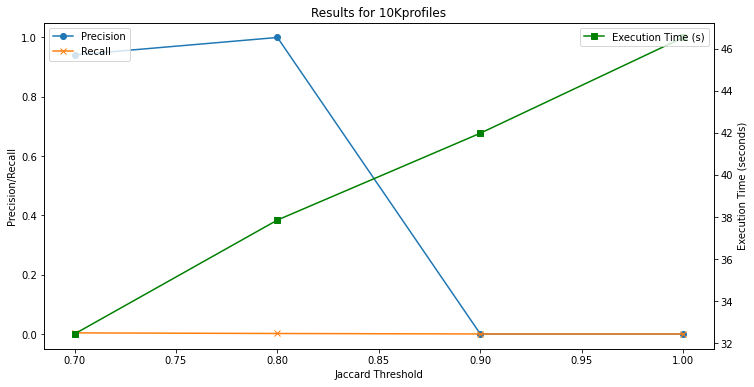

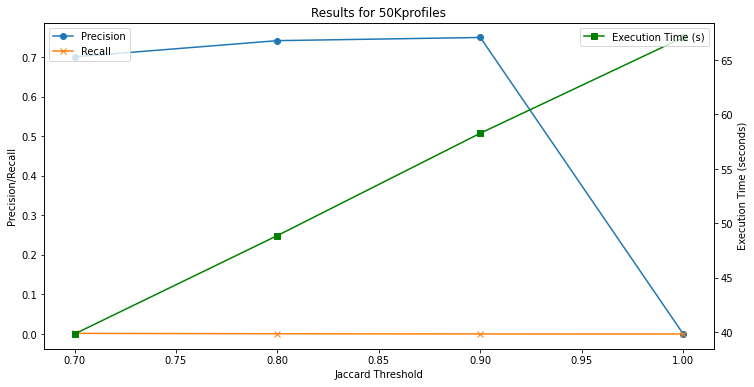

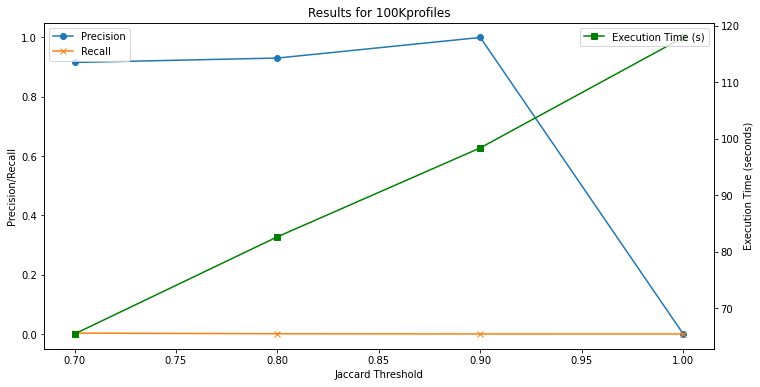

In [0]:
import matplotlib.pyplot as plt

for dataset in datasets:
    precisions = [results[(dataset, t)][0] for t in thresholds]
    recalls = [results[(dataset, t)][1] for t in thresholds]
    exec_times = [results[(dataset, t)][2] for t in thresholds]

    # Extract dataset name for title
    dataset_name = dataset.split('/')[-1].split('.')[0]  # Adjust this based on your actual path format

    plt.figure(figsize=(12, 6))

    # Plot Precision and Recall
    plt.plot(thresholds, precisions, label='Precision', marker='o')
    plt.plot(thresholds, recalls, label='Recall', marker='x')

    plt.xlabel('Jaccard Threshold')
    plt.ylabel('Precision/Recall')
    plt.title(f'Results for {dataset_name}')
    plt.legend(loc='upper left')

    # Plot Execution Time on a secondary axis
    ax2 = plt.gca().twinx()
    ax2.plot(thresholds, exec_times, label='Execution Time (s)', color='green', marker='s')
    ax2.set_ylabel('Execution Time (seconds)')
    ax2.legend(loc='upper right')

    plt.show()

### DEBUGGING PIPELINE

In [0]:
#PRE-PROCESSING
preprocessing_pipeline = PreprocessingPipeline("/FileStore/shared_uploads/datasets/50Kprofiles.json")
sorted_tokens_rdd, tokenized_rdd = preprocessing_pipeline.run()

print("Sample of tokenized records: \n")
for record in sorted_tokens_rdd.take(2):
    print(record)


#PREFIX-FILTERING
prefix_filtering_pipeline = PrefixFilteringPipeline(sorted_tokens_rdd, t=36)
distinct_pairs_rdd = prefix_filtering_pipeline.run()

# Testing
print(f"\nCandidate Pairs after Prefix Filter: {distinct_pairs_rdd.count()}","\n")
sample_candidate_pairs = distinct_pairs_rdd.take(3)
print("A sample of candidate pairs:","\n")
for pair in sample_candidate_pairs:
    print(pair)



#LENGHT-FILTERING
length_filtering_pipeline = LengthFilteringPipeline(tokenized_rdd, distinct_pairs_rdd, threshold=0.70)
final_pairs_rdd = length_filtering_pipeline.run()

# Testing
print(f"\nCandidate Pairs after Length Filter: {final_pairs_rdd.count()}","\n")
sample_final_pairs = final_pairs_rdd.take(3)
print("A sample of candidate pairs:","\n")
for pair in sample_final_pairs:
    print(pair)



#POSITIONAL-FILTERING
def positional_filtering(tokenized_rdd, final_pairs_rdd, similarity_threshold, max_positional_difference):
    # Token Positioning
    positioned_rdd = tokenized_rdd.mapValues(position_tokens)
    positioned_rdd = positioned_rdd.cache()
    
    # Join the candidate pairs with the positioned RDD based on tokens
    first_join = final_pairs_rdd.join(positioned_rdd)
    
    # Reformat the RID and token, then join again
    second_join = first_join.map(lambda kv: (kv[1][0], (kv[0], kv[1][1]))).join(positioned_rdd)
    
    # Filter out the pairs of records that don't satisfy the positional constraint
    filtered_positional_rdd = second_join.filter(
        lambda pair: positional_filter_optimized(pair, similarity_threshold, max_positional_difference))
    
    # Extract Candidate Pairs and sort them
    candidate_pairs_final_rdd = filtered_positional_rdd.map(lambda x: (x[1][0][0], x[0])).map(lambda x: tuple(sorted(x)))

    candidate_pairs_final_rdd = candidate_pairs_final_rdd.cache()
    return candidate_pairs_final_rdd


similarity_threshold = 10  # The number of min. common tokens required for a pair to be considered similar
max_positional_difference = 10  # The maximum allowed positional difference between tokens
candidate_pairs_final_rdd = positional_filtering(tokenized_rdd, final_pairs_rdd, similarity_threshold, max_positional_difference)

# Testing
print(f"\nCandidate pairs after positional filtering: {candidate_pairs_final_rdd.count()}","\n")


# JACCARD SIMILARITY
jaccard_threshold = 0.7
filtered_jaccard_rdd = jaccard_similarity_filtering(candidate_pairs_final_rdd, tokenized_rdd, jaccard_threshold)

# Testing
print(f"Sample of pairs with Jaccard sim >= {jaccard_threshold}:", filtered_jaccard_rdd.take(5),"\n")
print(f"Number of pairs with Jaccard sim >= {jaccard_threshold}:", filtered_jaccard_rdd.count(),"\n")


# Load Ground Truth
ground_truth_path = "/FileStore/shared_uploads/datasets/50KIdDuplicates.json"
ground_truth_rdd = load_ground_truth(ground_truth_path)

print("\nSample of pairs from Ground Truth dataset: ")
for pairs in ground_truth_rdd.take(3):
    print(pairs)

Sample of tokenized records: 

('0', ['dty', 'yld', 'ldt', 'tyn', 'bom', 'tyl', 'jer', 'abo', 'raa', 'aav', 'yne', 'gol', 'lde', '675', '576', 'rab', '767', '752', 'old', 'eid', 'cho', '551', 'rei', 'omb', '257', '115', 'nic', 'mbe', '955', '520', '790', '703', 'las', '113', 'ola', 'hol', '511', '130', '907', '036', 'ich', '204', 'enu', '025', 'nue', '211', 'err', 'ven', 'den', '070', 'ave', 'rra', 'ber', '195', '191', 'nsw'])
('1', ['mey', 'eye', 'rsp', 'roy', 'yer', '646', '681', '364', 'spl', '815', '468', '521', '821', 'aro', '982', 'por', 'orr', '270', '705', '150', '506', '130', '313', '215', '052', '036', 'gar', 'kin', 'nga', '210', '102', 'rra', '020', 'lle', 'ers', '198', 'ing', 'ell', 'pla', 'ace', 'lac'])
